## Import Module

In [149]:
import numpy as np
import pandas as pd
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from wordcloud import WordCloud, STOPWORDS 
import random
import time
import re 
import string
import nltk

from sklearn.model_selection import train_test_split,RepeatedStratifiedKFold

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn import metrics

from imblearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import plot_confusion_matrix, f1_score,auc,roc_curve,roc_auc_score, log_loss, make_scorer, precision_recall_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

pd.options.mode.chained_assignment = None  # default value='warn'

In [152]:
df2 = pd.read_csv('df_clean_text.csv')

In [153]:
df2.head(2)

,complaint_date,product,complaint_narrative,product_id,text_length,complaint_processed,clean_text
0,8/9/2019,"Money transfer, virtual currency, or money ser...","In an attempt to purchase concert tickets, I c...",0,1518,attempt purchase concert tickets communicated ...,attempt purchase concert tickets communicated ...
1,1/27/2020,Credit or prepaid card,In XX/XX/2019 I called Chase to discuss my cre...,1,1467,called discuss credit card bill also close acc...,called chase discuss credit card bill also clo...


In [154]:
df2.shape

(11831, 7)

In [155]:
products = df2.groupby('product').size()
products.sort_values(ascending = False, inplace = True)
print(products)

product
Credit or prepaid card                                4111
Checking or savings account                           3364
Credit reporting, repair, or other                    1636
Payday, title, or personal loan                       1390
Money transfer, virtual currency, or money service     754
Debt collection                                        517
Bank account or other service                           59
dtype: int64


## Merging relevant classes

In [156]:
df2.replace({'product':
             {
    'Money transfer, virtual currency, or money service':'Bank account, debt, money or other service',
    'Debt collection':'Bank account, debt, money or other service',
    'Bank account or other service':'Bank account, debt, money or other service'
    
    
}}, inplace = True)

In [157]:
#checking product classes again
products = df2.groupby('product').size()
products.sort_values(ascending = False, inplace = True)
print(products)

product
Credit or prepaid card                        4111
Checking or savings account                   3364
Credit reporting, repair, or other            1636
Payday, title, or personal loan               1390
Bank account, debt, money or other service    1330
dtype: int64


In [5]:
# Merging some of the product categories and renaming for better understanding
#df2.replace({'product': 
             {'Credit reporting, credit repair services, or other personal consumer reports': 
              'Credit reporting, repair, or other', 
              'Credit reporting': 'Credit reporting, repair, or other',
             'Credit card': 'Credit or prepaid card',
             'Credit card or prepaid card': 'Credit or prepaid card', 
             'Prepaid card': 'Credit or prepaid card',
             'Payday loan, title loan, or personal loan': 'Payday, title, or personal loan',
             'Money transfers': 'Money transfer, virtual currency, or money service',
             'Consumer Loan':'Payday, title, or personal loan',
             'Student loan': 'Payday, title, or personal loan',
             'Vehicle loan or lease':'Payday, title, or personal loan',
              'Bank account or service':'Bank account or other service',
             'Other financial service':'Bank account or other service',
             'Mortgage':'Payday, title, or personal loan',
             'Debt collection': 'Bank account or other service'
              
              
             }},inplace = True)

In [158]:
# Now mapping each class with specific value for further use
df2['product_id'] = df2['product'].factorize()[0]

In [159]:
# check uinque of product_id column
df2.product_id.unique()

array([0, 1, 2, 3, 4], dtype=int64)

In [27]:
tfidf = TfidfVectorizer(sublinear_tf =True, # log form for frequency
                        min_df=5, # minimun number of documents a word must be present
                        use_idf = True, # 
                        norm = u'l2', # set euclidian norm of 1
                        ngram_range = (1,2), # consider unigram and bigram
                        smooth_idf = True, 
                        stop_words = 'english' # remove pronouns, remove noisy features
                       )

# Applying the vectorizer
X = tfidf.fit_transform(df2.clean_text)

In [28]:
X.shape

(11831, 36971)

In [29]:
y = df2['product_id']

In [30]:
# Train Test and Split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=44)

### Metrics

In [112]:
# Global Metrics variable
model_metrics = {'model':[],'accuracy':[],'roc_auc_score':[],'F1-score(1)':[],'F1-score(2)':[],'F1-score(3)':[]}

In [145]:
model_metrics

{'model': ['Random Forest(base)',
  'Random Forest(tuned)',
  'Logistic Regression(base)',
  'Logistic Regression(tuned)',
  'Naive bayes(base)',
  'Naive bayes(tuned)',
  'Linear SVC(base)',
  'Linear SVC(tuned)',
  'XGBoost(base)',
  'XGBoost(tuned)'],
 'accuracy': ['0.78',
  '0.74',
  '0.82',
  '0.82',
  '0.71',
  '0.71',
  '0.83',
  '0.82',
  '0.80',
  '0.77'],
 'roc_auc_score': ['0.92',
  '0.94',
  '0.95',
  '0.95',
  '0.93',
  '0.93',
  '0.95',
  '0.95',
  '0.94',
  '0.91'],
 'F1-score(1)': ['0.84',
  '0.79',
  '0.88',
  '0.88',
  '0.78',
  '0.78',
  '0.88',
  '0.88',
  '0.85',
  '0.83'],
 'F1-score(2)': ['0.81',
  '0.81',
  '0.86',
  '0.86',
  '0.81',
  '0.81',
  '0.86',
  '0.85',
  '0.83',
  '0.80'],
 'F1-score(3)': ['0.82',
  '0.77',
  '0.86',
  '0.85',
  '0.62',
  '0.62',
  '0.86',
  '0.86',
  '0.84',
  '0.81']}

## A. Random Forest

### Random Forest(base)

              precision    recall  f1-score   support

           0       0.76      0.25      0.37       247
           1       0.79      0.89      0.84       853
           2       0.75      0.88      0.81       674
           3       0.85      0.79      0.82       275
           4       0.75      0.65      0.70       318

    accuracy                           0.78      2367
   macro avg       0.78      0.69      0.71      2367
weighted avg       0.78      0.78      0.76      2367

roc_auc_score: 0.924681


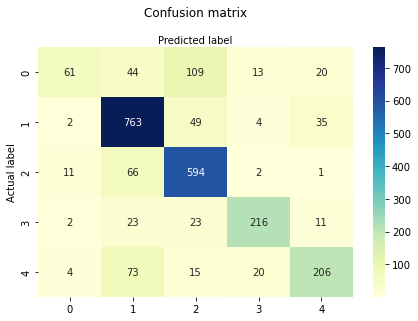

In [91]:
rf_clf = RandomForestClassifier(n_estimators=24, random_state=64)
rf_clf.fit(X_train, y_train)

rf_predict =rf_clf.predict(X_test)
rf_pred_proba =rf_clf.predict_proba(X_test)

cnf_matrix = metrics.confusion_matrix(y_test, rf_predict)

class_names=[0,1,2,3,4] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print(classification_report(y_test,rf_predict, labels=np.unique(rf_predict)))

print('roc_auc_score: {:3f}'.format(roc_auc_score(y_test, rf_pred_proba, multi_class = 'ovr')))

#### Append Metrics Random Forest(base)

In [114]:
#model_metrics['model']
model_metrics['model'].append('Random Forest(base)')
#model_metrics['accuracy']
model_metrics['accuracy'].append(format(metrics.accuracy_score(y_test, rf_predict, sample_weight = None),'.2f'))
#model_metrics['roc_auc_score']
model_metrics['roc_auc_score'].append(format(roc_auc_score(y_test, rf_pred_proba, multi_class = 'ovr'),'.2f'))
#model_metrics['F1-score(1)']
model_metrics['F1-score(1)'].append(format(metrics.f1_score(y_test, rf_predict, average = 'weighted', labels = [1]),'.2f'))
#model_metrics['F1-score(2)']
model_metrics['F1-score(2)'].append(format(metrics.f1_score(y_test, rf_predict, average = 'weighted', labels = [2]),'.2f'))
#model_metrics['F1-score(3)']
model_metrics['F1-score(3)'].append(format(metrics.f1_score(y_test, rf_predict, average = 'weighted', labels = [3]),'.2f'))

### Random Forest(tuned)

In [34]:
rft_clf = RandomForestClassifier(random_state=64)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=44)
param_grid = {'n_estimators': range(100,200,5),
               'max_features': ['auto', 'sqrt'],
               'max_depth':[10,15,20],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1,2,4],
               'bootstrap':[True, False]}
rft_grid = GridSearchCV(rft_clf, param_grid= param_grid,
                    cv = cv,
                    n_jobs = -1,
                   verbose = 2)
rft_grid.fit(X_train, y_train)
rft_predict = rft_grid.predict(X_test)
rft_pred_proba =rft_grid.predict_proba(X_test)

Fitting 5 folds for each of 2160 candidates, totalling 10800 fits


In [35]:
rft_grid.best_params_

{'bootstrap': False,
 'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 195}

              precision    recall  f1-score   support

           0       1.00      0.03      0.06       247
           1       0.68      0.95      0.79       853
           2       0.75      0.87      0.81       674
           3       0.89      0.68      0.77       275
           4       0.85      0.48      0.62       318

    accuracy                           0.74      2367
   macro avg       0.83      0.60      0.61      2367
weighted avg       0.78      0.74      0.69      2367

Accuracy Score = 0.736
roc_auc_score: 0.937166


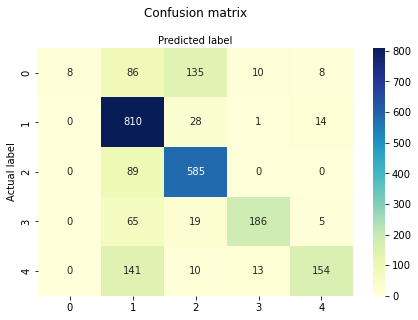

In [95]:
print(classification_report(y_test,rft_predict, labels=np.unique(rft_predict)))

cnf_matrix = metrics.confusion_matrix(y_test, rft_predict)

class_names=[0,1,2,3,4] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print('Accuracy Score = {:.3f}'.format(metrics.accuracy_score(y_test, rft_predict, sample_weight = None)))
print('roc_auc_score: {:3f}'.format(roc_auc_score(y_test, rft_pred_proba, multi_class = 'ovr')))

#### Append Metrics Random Forest(tuned)

In [115]:
#model_metrics['model']
model_metrics['model'].append('Random Forest(tuned)')
#model_metrics['accuracy']
model_metrics['accuracy'].append(format(metrics.accuracy_score(y_test, rft_predict, sample_weight = None),'.2f'))
#model_metrics['roc_auc_score']
model_metrics['roc_auc_score'].append(format(roc_auc_score(y_test, rft_pred_proba, multi_class = 'ovr'),'.2f'))
#model_metrics['F1-score(1)']
model_metrics['F1-score(1)'].append(format(metrics.f1_score(y_test, rft_predict, average = 'weighted', labels = [1]),'.2f'))
#model_metrics['F1-score(2)']
model_metrics['F1-score(2)'].append(format(metrics.f1_score(y_test, rft_predict, average = 'weighted', labels = [2]),'.2f'))
#model_metrics['F1-score(3)']
model_metrics['F1-score(3)'].append(format(metrics.f1_score(y_test, rft_predict, average = 'weighted', labels = [3]),'.2f'))

## B. Logistic Regression

### Logistic Regression(base)

In [100]:
lr_clf = LogisticRegression(solver='lbfgs',max_iter= 200, multi_class='multinomial', random_state = 44)
lr_clf.fit(X_train, y_train)

lr_predict = lr_clf.predict(X_test)
lr_pred_proba =lr_clf.predict_proba(X_test)

              precision    recall  f1-score   support

           0       0.74      0.38      0.51       247
           1       0.84      0.91      0.88       853
           2       0.82      0.91      0.86       674
           3       0.86      0.86      0.86       275
           4       0.74      0.70      0.72       318

    accuracy                           0.82      2367
   macro avg       0.80      0.75      0.77      2367
weighted avg       0.81      0.82      0.81      2367

roc_auc_score: 0.950938


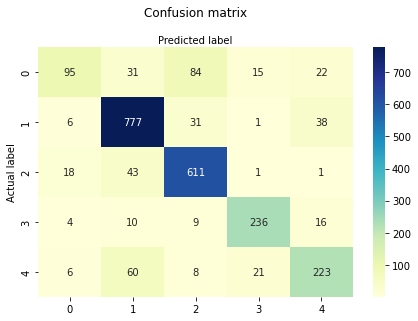

In [109]:
cnf_matrix = metrics.confusion_matrix(y_test, lr_predict)

class_names=[0,1,2,3,4] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print(classification_report(y_test,lr_predict, labels=np.unique(lr_predict)))
print('roc_auc_score: {:3f}'.format(roc_auc_score(y_test, lr_pred_proba, multi_class = 'ovr')))

#### Append Metrics Logistic Regression(base)

In [116]:
#model_metrics['model']
model_metrics['model'].append('Logistic Regression(base)')
#model_metrics['accuracy']
model_metrics['accuracy'].append(format(metrics.accuracy_score(y_test, lr_predict, sample_weight = None),'.2f'))
#model_metrics['roc_auc_score']
model_metrics['roc_auc_score'].append(format(roc_auc_score(y_test, lr_pred_proba, multi_class = 'ovr'),'.2f'))
#model_metrics['F1-score(1)']
model_metrics['F1-score(1)'].append(format(metrics.f1_score(y_test, lr_predict, average = 'weighted', labels = [1]),'.2f'))
#model_metrics['F1-score(2)']
model_metrics['F1-score(2)'].append(format(metrics.f1_score(y_test, lr_predict, average = 'weighted', labels = [2]),'.2f'))
#model_metrics['F1-score(3)']
model_metrics['F1-score(3)'].append(format(metrics.f1_score(y_test, lr_predict, average = 'weighted', labels = [3]),'.2f'))

### Logistic Regression(tuned)

In [104]:
#time_start = time.time()
lrt_clf = LogisticRegression()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=44)
param_grid = {
    'penalty': ['l2'],
    'C': np.logspace(-4,4,20),
    'solver': ['lbfgs'],
    'multi_class':['multinomial'],
    'max_iter':[500],
    'random_state': [44]
    
}
grid = GridSearchCV(lrt_clf, param_grid = param_grid, cv =cv, n_jobs = -1, verbose = 2)
grid.fit(X_train, y_train)
grid.best_params_
#print('Execution time: {}'.format(time.time() - time_start))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


{'C': 4.281332398719396,
 'max_iter': 500,
 'multi_class': 'multinomial',
 'penalty': 'l2',
 'random_state': 44,
 'solver': 'lbfgs'}

              precision    recall  f1-score   support

           0       0.66      0.44      0.53       247
           1       0.86      0.90      0.88       853
           2       0.83      0.90      0.86       674
           3       0.85      0.85      0.85       275
           4       0.76      0.72      0.74       318

    accuracy                           0.82      2367
   macro avg       0.79      0.76      0.77      2367
weighted avg       0.82      0.82      0.82      2367

roc_auc_score: 0.952485


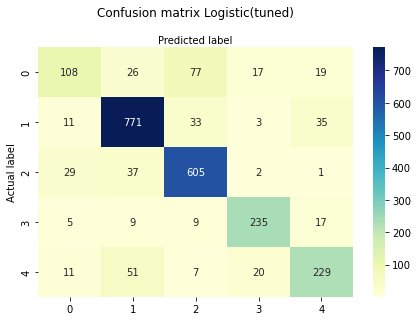

In [117]:
lrt_predict = grid.predict(X_test)
lrt_pred_proba =grid.predict_proba(X_test)

cnf_matrix = metrics.confusion_matrix(y_test, lrt_predict)

class_names=[0,1,2,3,4] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix Logistic(tuned)', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print(classification_report(y_test,lrt_predict, labels=np.unique(lrt_predict)))
print('roc_auc_score: {:3f}'.format(roc_auc_score(y_test, lrt_pred_proba, multi_class = 'ovr')))    

#### Append Metrics Logistic Regression(tuned)

In [118]:
#model_metrics['model']
model_metrics['model'].append('Logistic Regression(tuned)')
#model_metrics['accuracy']
model_metrics['accuracy'].append(format(metrics.accuracy_score(y_test, lrt_predict, sample_weight = None),'.2f'))
#model_metrics['roc_auc_score']
model_metrics['roc_auc_score'].append(format(roc_auc_score(y_test, lrt_pred_proba, multi_class = 'ovr'),'.2f'))
#model_metrics['F1-score(1)']
model_metrics['F1-score(1)'].append(format(metrics.f1_score(y_test, lrt_predict, average = 'weighted', labels = [1]),'.2f'))
#model_metrics['F1-score(2)']
model_metrics['F1-score(2)'].append(format(metrics.f1_score(y_test, lrt_predict, average = 'weighted', labels = [2]),'.2f'))
#model_metrics['F1-score(3)']
model_metrics['F1-score(3)'].append(format(metrics.f1_score(y_test, lrt_predict, average = 'weighted', labels = [3]),'.2f'))

## C. Multinomial Naive bayes

### Naive bayes(base)

In [108]:
## Training the model wiht naive bayes text classification
nb = MultinomialNB()
nb.fit(X_train,y_train)

# predictions
nb_predict = nb.predict(X_test)
nb_pred_proba = nb.predict_proba(X_test)


              precision    recall  f1-score   support

           0       0.88      0.03      0.05       247
           1       0.66      0.95      0.78       853
           2       0.75      0.89      0.81       674
           3       0.89      0.48      0.62       275
           4       0.80      0.44      0.57       318

    accuracy                           0.71      2367
   macro avg       0.79      0.56      0.57      2367
weighted avg       0.75      0.71      0.67      2367

roc_auc_score: 0.926804
Accuracy Score = 0.713


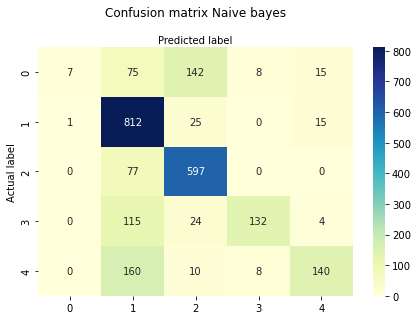

In [119]:
cnf_matrix = metrics.confusion_matrix(y_test, nb_predict)

class_names=[0,1,2,3,4] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix Naive bayes', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print(classification_report(y_test,nb_predict, labels=np.unique(nb_predict)))
print('roc_auc_score: {:3f}'.format(roc_auc_score(y_test, nb_pred_proba, multi_class = 'ovr')))
print('Accuracy Score = {:.3f}'.format(metrics.accuracy_score(y_test, nb_predict, sample_weight = None)))


#### Append Metrics Naive bayes(base)

In [120]:
#model_metrics['model']
model_metrics['model'].append('Naive bayes(base)')
#model_metrics['accuracy']
model_metrics['accuracy'].append(format(metrics.accuracy_score(y_test, nb_predict, sample_weight = None),'.2f'))
#model_metrics['roc_auc_score']
model_metrics['roc_auc_score'].append(format(roc_auc_score(y_test, nb_pred_proba, multi_class = 'ovr'),'.2f'))
#model_metrics['F1-score(1)']
model_metrics['F1-score(1)'].append(format(metrics.f1_score(y_test, nb_predict, average = 'weighted', labels = [1]),'.2f'))
#model_metrics['F1-score(2)']
model_metrics['F1-score(2)'].append(format(metrics.f1_score(y_test, nb_predict, average = 'weighted', labels = [2]),'.2f'))
#model_metrics['F1-score(3)']
model_metrics['F1-score(3)'].append(format(metrics.f1_score(y_test, nb_predict, average = 'weighted', labels = [3]),'.2f'))

### Naive bayes(tuned)

In [122]:
nbt = MultinomialNB()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=44)

param_grid = {'alpha':[1],
              'class_prior':[None],
              'fit_prior':[True]               
}
grid = GridSearchCV(nbt, param_grid = param_grid, cv =cv, n_jobs = -1, verbose = 2)
grid.fit(X_train, y_train)
grid.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


{'alpha': 1, 'class_prior': None, 'fit_prior': True}

              precision    recall  f1-score   support

           0       0.88      0.03      0.05       247
           1       0.66      0.95      0.78       853
           2       0.75      0.89      0.81       674
           3       0.89      0.48      0.62       275
           4       0.80      0.44      0.57       318

    accuracy                           0.71      2367
   macro avg       0.79      0.56      0.57      2367
weighted avg       0.75      0.71      0.67      2367

roc_auc_score: 0.926804
Accuracy Score = 0.713


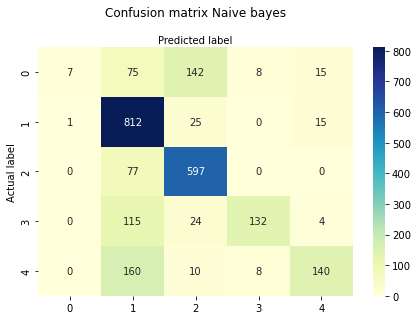

In [123]:
# predictions
nbt_predict = grid.predict(X_test)
nbt_pred_proba = grid.predict_proba(X_test)

cnf_matrix = metrics.confusion_matrix(y_test, nbt_predict)

class_names=[0,1,2,3,4] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix Naive bayes', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print(classification_report(y_test,nbt_predict, labels=np.unique(nbt_predict)))
print('roc_auc_score: {:3f}'.format(roc_auc_score(y_test, nbt_pred_proba, multi_class = 'ovr')))
print('Accuracy Score = {:.3f}'.format(metrics.accuracy_score(y_test, nbt_predict, sample_weight = None)))

#### Append Metrics Naive bayes(tuned)

In [124]:
#model_metrics['model']
model_metrics['model'].append('Naive bayes(tuned)')
#model_metrics['accuracy']
model_metrics['accuracy'].append(format(metrics.accuracy_score(y_test, nbt_predict, sample_weight = None),'.2f'))
#model_metrics['roc_auc_score']
model_metrics['roc_auc_score'].append(format(roc_auc_score(y_test, nbt_pred_proba, multi_class = 'ovr'),'.2f'))
#model_metrics['F1-score(1)']
model_metrics['F1-score(1)'].append(format(metrics.f1_score(y_test, nbt_predict, average = 'weighted', labels = [1]),'.2f'))
#model_metrics['F1-score(2)']
model_metrics['F1-score(2)'].append(format(metrics.f1_score(y_test, nbt_predict, average = 'weighted', labels = [2]),'.2f'))
#model_metrics['F1-score(3)']
model_metrics['F1-score(3)'].append(format(metrics.f1_score(y_test, nbt_predict, average = 'weighted', labels = [3]),'.2f'))

## D. Linear SVC

### Linear SVC(base)

              precision    recall  f1-score   support

           0       0.68      0.46      0.55       247
           1       0.86      0.91      0.88       853
           2       0.83      0.89      0.86       674
           3       0.86      0.86      0.86       275
           4       0.78      0.75      0.76       318

    accuracy                           0.83      2367
   macro avg       0.80      0.77      0.78      2367
weighted avg       0.82      0.83      0.82      2367



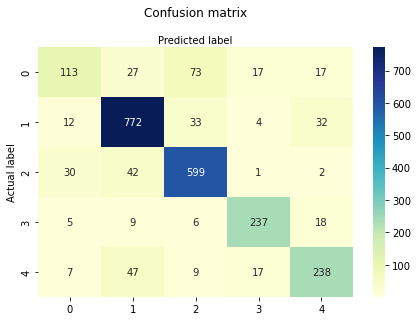

In [132]:
svc = LinearSVC()
svc.fit(X_train, y_train)
svc_predict = svc.predict(X_test) 

#---------------

cnf_matrix = metrics.confusion_matrix(y_test,svc_predict)

class_names=[0,1,2,3,4] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print(classification_report(y_test,svc_predict, labels=np.unique(svc_predict)))


In [127]:
from sklearn.calibration import CalibratedClassifierCV

In [129]:
#LinearSVC porbabilistic output for roc_auc_score
svm = LinearSVC()
clf = CalibratedClassifierCV(svm)
clf.fit(X_train,y_train)
svc_pred_proba = clf.predict_proba(X_test)
print('roc_auc_score: {:3f}'.format(roc_auc_score(y_test, svc_pred_proba, multi_class = 'ovr')))

roc_auc_score: 0.952279


#### Append Metrics Linear SVC(base)

In [130]:
#model_metrics['model']
model_metrics['model'].append('Linear SVC(base)')
#model_metrics['accuracy']
model_metrics['accuracy'].append(format(metrics.accuracy_score(y_test, svc_predict, sample_weight = None),'.2f'))
#model_metrics['roc_auc_score']
model_metrics['roc_auc_score'].append(format(roc_auc_score(y_test, svc_pred_proba, multi_class = 'ovr'),'.2f'))
#model_metrics['F1-score(1)']
model_metrics['F1-score(1)'].append(format(metrics.f1_score(y_test, svc_predict, average = 'weighted', labels = [1]),'.2f'))
#model_metrics['F1-score(2)']
model_metrics['F1-score(2)'].append(format(metrics.f1_score(y_test, svc_predict, average = 'weighted', labels = [2]),'.2f'))
#model_metrics['F1-score(3)']
model_metrics['F1-score(3)'].append(format(metrics.f1_score(y_test, svc_predict, average = 'weighted', labels = [3]),'.2f'))

### Linear SVC(tuned)

In [133]:
svct = LinearSVC()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=44)
param_grid = {
    'penalty': ['l2'],
    'C': np.logspace(1,4,20),
    'multi_class':['ovr'],
    'max_iter':[700,800,1000],
    'random_state': [44]
    
}
grid = GridSearchCV(svct, param_grid = param_grid,
                    cv=cv,
                    n_jobs = -1,
                    verbose = 2
                   )
grid.fit(X_train, y_train)
grid.best_params_

Fitting 5 folds for each of 60 candidates, totalling 300 fits


{'C': 10.0,
 'max_iter': 700,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': 44}

              precision    recall  f1-score   support

           0       0.62      0.49      0.55       247
           1       0.86      0.90      0.88       853
           2       0.83      0.86      0.85       674
           3       0.86      0.86      0.86       275
           4       0.77      0.74      0.76       318

    accuracy                           0.82      2367
   macro avg       0.79      0.77      0.78      2367
weighted avg       0.81      0.82      0.82      2367



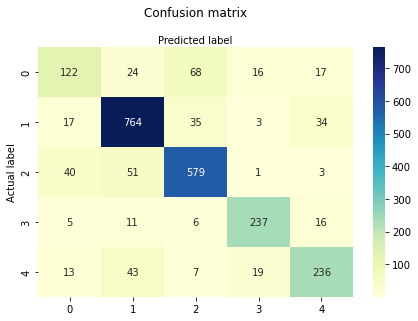

In [134]:
svct_predict = grid.predict(X_test)

cnf_matrix = metrics.confusion_matrix(y_test, svct_predict)

class_names=[0,1,2,3,4] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print(classification_report(y_test,svct_predict, labels=np.unique(svct_predict)))

In [135]:
#LinearSVC porbabilistic output for roc_auc_score using the best parameter after tuning
svm = LinearSVC(C= 10.0,
 max_iter= 700,
 multi_class= 'ovr',
 penalty= 'l2',
 random_state= 44)
clf = CalibratedClassifierCV(svm)
clf.fit(X_train,y_train)
svct_pred_proba = clf.predict_proba(X_test)
print('roc_auc_score: {:3f}'.format(roc_auc_score(y_test, svct_pred_proba, multi_class = 'ovr')))

roc_auc_score: 0.948302


#### Append Metrics Linear SVC(tuned)

In [136]:
#model_metrics['model']
model_metrics['model'].append('Linear SVC(tuned)')
#model_metrics['accuracy']
model_metrics['accuracy'].append(format(metrics.accuracy_score(y_test, svct_predict, sample_weight = None),'.2f'))
#model_metrics['roc_auc_score']
model_metrics['roc_auc_score'].append(format(roc_auc_score(y_test, svct_pred_proba, multi_class = 'ovr'),'.2f'))
#model_metrics['F1-score(1)']
model_metrics['F1-score(1)'].append(format(metrics.f1_score(y_test, svct_predict, average = 'weighted', labels = [1]),'.2f'))
#model_metrics['F1-score(2)']
model_metrics['F1-score(2)'].append(format(metrics.f1_score(y_test, svct_predict, average = 'weighted', labels = [2]),'.2f'))
#model_metrics['F1-score(3)']
model_metrics['F1-score(3)'].append(format(metrics.f1_score(y_test, svct_predict, average = 'weighted', labels = [3]),'.2f'))

## E. XGBoost

### XGB(base)

              precision    recall  f1-score   support

           0       0.66      0.41      0.51       247
           1       0.84      0.87      0.85       853
           2       0.80      0.87      0.83       674
           3       0.84      0.85      0.84       275
           4       0.72      0.71      0.72       318

    accuracy                           0.80      2367
   macro avg       0.77      0.74      0.75      2367
weighted avg       0.79      0.80      0.79      2367

roc_auc_score: 0.942358


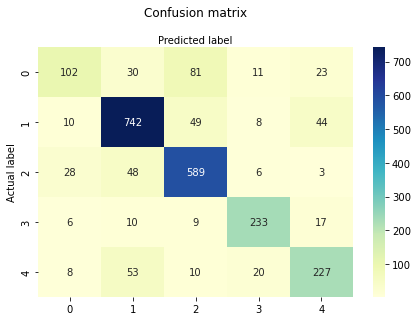

In [138]:

xgb = XGBClassifier(num_class = 6,
                   objective = 'multi:softprob',
                   eval_metric ='mlogloss',
                   use_label_encoder=False,
                   seed =44)

xgb.fit(X_train, y_train)
xgb_predict = xgb.predict(X_test) 
xgb_pred_proba = xgb.predict_proba(X_test)
#---------------

cnf_matrix = metrics.confusion_matrix(y_test, xgb_predict)

class_names=[0,1,2,3,4] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print(classification_report(y_test,xgb_predict, labels=np.unique(xgb_predict)))
print('roc_auc_score: {:3f}'.format(roc_auc_score(y_test, xgb_pred_proba, multi_class = 'ovr')))

#### Append Metrics XGBoost(base)

In [139]:
#model_metrics['model']
model_metrics['model'].append('XGBoost(base)')
#model_metrics['accuracy']
model_metrics['accuracy'].append(format(metrics.accuracy_score(y_test, xgb_predict, sample_weight = None),'.2f'))
#model_metrics['roc_auc_score']
model_metrics['roc_auc_score'].append(format(roc_auc_score(y_test, xgb_pred_proba, multi_class = 'ovr'),'.2f'))
#model_metrics['F1-score(1)']
model_metrics['F1-score(1)'].append(format(metrics.f1_score(y_test, xgb_predict, average = 'weighted', labels = [1]),'.2f'))
#model_metrics['F1-score(2)']
model_metrics['F1-score(2)'].append(format(metrics.f1_score(y_test, xgb_predict, average = 'weighted', labels = [2]),'.2f'))
#model_metrics['F1-score(3)']
model_metrics['F1-score(3)'].append(format(metrics.f1_score(y_test, xgb_predict, average = 'weighted', labels = [3]),'.2f'))

### XGB -tuned

In [141]:
xgbt = XGBClassifier(num_class = 6,
                   objective = 'multi:softprob',
                   eval_metric ='mlogloss',
                   use_label_encoder=False,
                   seed =44)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1) # stratified KFold considering imbalanced classes
param_grid = {"max_depth": [10,15,20],
              "n_estimators": range(5,20,5) , 
              "gamma": [0.03,0.05], 
              "learning_rate": [0.01,0.05]}
grid = GridSearchCV(xgbt, param_grid= param_grid,
                    cv = cv,
                    n_jobs = -1,
                    scoring = 'neg_log_loss',
                   verbose = 2)
grid.fit(X_train, y_train)
grid.best_params_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


{'gamma': 0.05, 'learning_rate': 0.05, 'max_depth': 20, 'n_estimators': 15}

In [142]:
#grid.fit(X_train, y_train)
xgbt_predict = grid.predict(X_test)
xgbt_pred_proba = grid.predict_proba(X_test)

              precision    recall  f1-score   support

           0       0.59      0.36      0.45       247
           1       0.81      0.86      0.83       853
           2       0.77      0.83      0.80       674
           3       0.80      0.82      0.81       275
           4       0.70      0.68      0.69       318

    accuracy                           0.77      2367
   macro avg       0.74      0.71      0.72      2367
weighted avg       0.76      0.77      0.76      2367

roc_auc_score: 0.912518


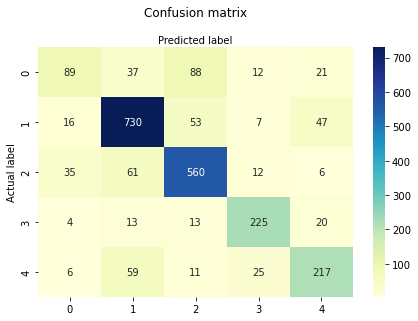

In [143]:
cnf_matrix = metrics.confusion_matrix(y_test, xgbt_predict)

class_names=[0,1,2,3,4] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print(classification_report(y_test,xgbt_predict, labels=np.unique(xgbt_predict)))
print('roc_auc_score: {:3f}'.format(roc_auc_score(y_test, xgbt_pred_proba, multi_class = 'ovr')))

#### Append Metrics XGBoost(tuned)

In [144]:
#model_metrics['model']
model_metrics['model'].append('XGBoost(tuned)')
#model_metrics['accuracy']
model_metrics['accuracy'].append(format(metrics.accuracy_score(y_test, xgbt_predict, sample_weight = None),'.2f'))
#model_metrics['roc_auc_score']
model_metrics['roc_auc_score'].append(format(roc_auc_score(y_test, xgbt_pred_proba, multi_class = 'ovr'),'.2f'))
#model_metrics['F1-score(1)']
model_metrics['F1-score(1)'].append(format(metrics.f1_score(y_test, xgbt_predict, average = 'weighted', labels = [1]),'.2f'))
#model_metrics['F1-score(2)']
model_metrics['F1-score(2)'].append(format(metrics.f1_score(y_test, xgbt_predict, average = 'weighted', labels = [2]),'.2f'))
#model_metrics['F1-score(3)']
model_metrics['F1-score(3)'].append(format(metrics.f1_score(y_test, xgbt_predict, average = 'weighted', labels = [3]),'.2f'))

## Compiling metrics of the models used

In [146]:
# convert the model_metrics to df
metrics_compile = pd.DataFrame(model_metrics)

In [147]:
metrics_compile

,model,accuracy,roc_auc_score,F1-score(1),F1-score(2),F1-score(3)
0,Random Forest(base),0.78,0.92,0.84,0.81,0.82
1,Random Forest(tuned),0.74,0.94,0.79,0.81,0.77
2,Logistic Regression(base),0.82,0.95,0.88,0.86,0.86
3,Logistic Regression(tuned),0.82,0.95,0.88,0.86,0.85
4,Naive bayes(base),0.71,0.93,0.78,0.81,0.62
5,Naive bayes(tuned),0.71,0.93,0.78,0.81,0.62
6,Linear SVC(base),0.83,0.95,0.88,0.86,0.86
7,Linear SVC(tuned),0.82,0.95,0.88,0.85,0.86
8,XGBoost(base),0.80,0.94,0.85,0.83,0.84
9,XGBoost(tuned),0.77,0.91,0.83,0.80,0.81


## Feeding a single complaint in the model for prediction

#### Prediction using Logistic Regression (base)

In [160]:
df2.head(2)

,complaint_date,product,complaint_narrative,product_id,text_length,complaint_processed,clean_text
0,8/9/2019,"Bank account, debt, money or other service","In an attempt to purchase concert tickets, I c...",0,1518,attempt purchase concert tickets communicated ...,attempt purchase concert tickets communicated ...
1,1/27/2020,Credit or prepaid card,In XX/XX/2019 I called Chase to discuss my cre...,1,1467,called discuss credit card bill also close acc...,called chase discuss credit card bill also clo...


In [169]:
X = df2['clean_text']
y = df2['product_id']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 44)

tfidf = TfidfVectorizer(sublinear_tf =True,
                        min_df=5, 
                        use_idf = True, 
                        norm = u'l2', 
                        ngram_range = (1,2), 
                        smooth_idf = True, 
                        stop_words = 'english' 
                       )

# Applying the vectorizer
fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)
model = LogisticRegression(penalty= 'l2',
    C=4.281332398719396,
    solver= 'lbfgs',
    multi_class='multinomial',
    max_iter=500,
    random_state = 44).fit(tfidf_vectorizer_vectors, y_train)


In [185]:
new_complaint = X_test.values[444]
print(model.predict(fitted_vectorizer.transform([new_complaint])))

[3]


Logistic Regression predicted wrong, that belongs to class = 0

In [186]:
df2[df2['clean_text']== new_complaint]

,complaint_date,product,complaint_narrative,product_id,text_length,complaint_processed,clean_text
7359,2/15/2019,"Bank account, debt, money or other service",XXXX systematically fails to process Co-Borrow...,0,1668,systematically fails process coborrower releas...,systematically fails process coborrower releas...


In [187]:
new_complaint_2 = X_test.values[11]
print(model.predict(fitted_vectorizer.transform([new_complaint_2])))
print(new_complaint_2)

[1]
went chasecom attempt dispute charge apparent mechanism initiate dispute website logged account written video instructions following url apparently obsolete longer applicable called chase bank report problem website transaction put hold minutes disconnected


In [176]:
df2[df2['clean_text']== new_complaint_2]

,complaint_date,product,complaint_narrative,product_id,text_length,complaint_processed,clean_text
4046,9/17/2021,Credit or prepaid card,Went to chase.com to attempt to dispute a char...,1,426,went chasecom attempt dispute charge apparent ...,went chasecom attempt dispute charge apparent ...


This complaint has been predicted correct which belongs to class 1

#### Prediction using Linear SVC(base)

In [188]:
X = df2['clean_text']
y = df2['product_id']



X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf =True, 
                        min_df=5, 
                        use_idf = True, 
                        norm = u'l2', 
                        ngram_range = (1,2), 
                        smooth_idf = True, 
                        stop_words = 'english' 
                       )

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

model_svc = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

In [191]:
new_complaint = X_test.values[444]
print(model_svc.predict(fitted_vectorizer.transform([new_complaint])))
print(new_complaint)

[1]
given checking account number routing pay credit card balance credit card balance days showed balance asked return make payment someone promise would paid checking account paid credit card original payment returned insufficient funds told send back bank messed definitaley money account pay balance submitted payment transaction amound returned insufficient funds disputed transaction sent requested information received letter dispute settled responsible transaction


Linear SVC predicted correctly

In [192]:
df2[df2['clean_text']== new_complaint]

,complaint_date,product,complaint_narrative,product_id,text_length,complaint_processed,clean_text
10295,4/28/2021,Credit or prepaid card,On XX/XX/21 I was given a checking account num...,1,924,given checking account number routing pay cred...,given checking account number routing pay cred...


## Appendix

In [36]:
import sklearn
sklearn.__version__

'1.0.1'